In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from tqdm import tqdm, tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
from collections import deque

from keras.models import load_model
import numpy

# 1. Preparación de los datos

Elegimos una accion y obtenemos sus datos historicos.

                               Open      High       Low     Close      Volume  \
Date                                                                            
1999-01-22 00:00:00-05:00  0.040119  0.044775  0.035581  0.037612  2714688000   
1999-01-25 00:00:00-05:00  0.040597  0.042029  0.037612  0.041552   510480000   
1999-01-26 00:00:00-05:00  0.042029  0.042865  0.037731  0.038328   343200000   
1999-01-27 00:00:00-05:00  0.038447  0.039403  0.036298  0.038209   244368000   
1999-01-28 00:00:00-05:00  0.038209  0.038447  0.037850  0.038089   227520000   

                           Dividends  Stock Splits  
Date                                                
1999-01-22 00:00:00-05:00        0.0           0.0  
1999-01-25 00:00:00-05:00        0.0           0.0  
1999-01-26 00:00:00-05:00        0.0           0.0  
1999-01-27 00:00:00-05:00        0.0           0.0  
1999-01-28 00:00:00-05:00        0.0           0.0  
                              Close      Volume
Date         

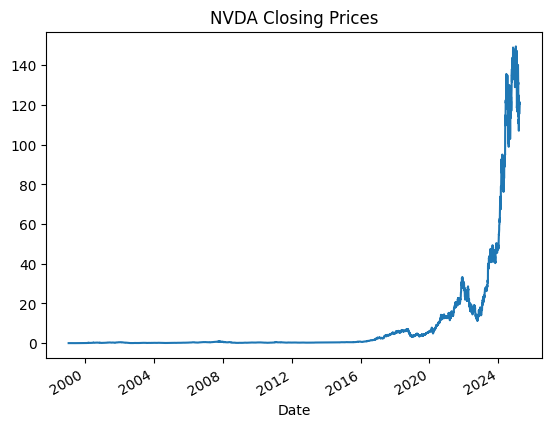

In [2]:
stock_name = "NVDA"

dataset = yf.Ticker(stock_name).history(period="max")

# Muestra las primeras entradas del dataset
print(dataset.head())

# Seleccionamos solo las columnas de cierre y volumen
data = dataset[['Close', 'Volume']]
print(data.head())

# Graficamos los precios de cierre
data['Close'].plot()
plt.title(f"{stock_name} Closing Prices")
plt.show()


A continuación, transformamos los datos y los normalizamos para poder entrenar nuestro modelo

In [3]:
# Usar ffill sin inplace para evitar SettingWithCopyWarning y asignar el resultado a data
data = data.ffill()

# Escalar 'Close' y 'Volume' con MinMaxScaler y asignar con loc para evitar problemas de tipos
scaler = MinMaxScaler()
data.loc[:, 'Close'] = scaler.fit_transform(data[['Close']].astype(float))
data.loc[:, 'Volume'] = scaler.fit_transform(data[['Volume']].astype(float))  # Convertir a float explícitamente

# Mostrar los datos normalizados
print(data.head())

                              Close    Volume
Date                                         
1999-01-22 00:00:00-05:00  0.000042  0.292580
1999-01-25 00:00:00-05:00  0.000069  0.053283
1999-01-26 00:00:00-05:00  0.000047  0.035123
1999-01-27 00:00:00-05:00  0.000046  0.024393
1999-01-28 00:00:00-05:00  0.000046  0.022564


C:\Users\soyun\AppData\Local\Temp\ipykernel_9296\1570816400.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.29258023 0.0532831  0.03512255 ... 0.02679555 0.02266513 0.01587005]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, 'Volume'] = scaler.fit_transform(data[['Volume']].astype(float))  # Convertir a float explícitamente


Calculamos el RSI

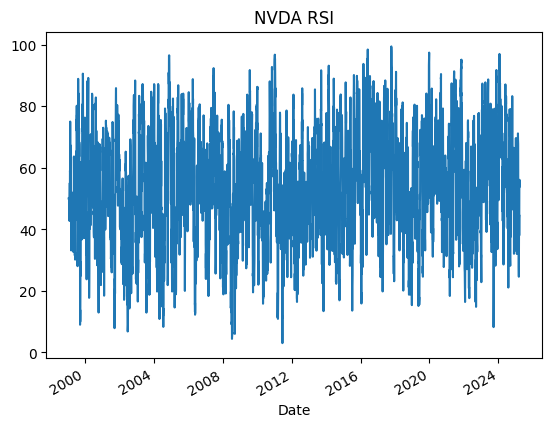

In [4]:
# Cálculo del RSI
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).fillna(0)
loss = (-delta.where(delta < 0, 0)).fillna(0)
average_gain = gain.rolling(window=14).mean()
average_loss = loss.rolling(window=14).mean()
rs = average_gain / average_loss
rsi = 100 - (100 / (1 + rs))
data['RSI'] = rsi.fillna(50)  # Inicializa el primer RSI a 50

# Visualizar el RSI
data['RSI'].plot()
plt.title(f"{stock_name} RSI")
plt.show()


# 2. Definición del modelo

Creamos el modelo y tras varias pruebas de parametros, elegimos los valores adecuados para gamma, epsilon, epsilon_final y epsilon_decay siendo estos el factor de descuento, la tasa de exploración inicial, la tasa de exploración minima y el factor de decaimiento de epsilon respectivamente.

In [5]:
import random
import numpy as np
from collections import deque
import tensorflow as tf

class AI_Trader():
    def __init__(self, state_size, action_space=3, model_name="AITrader"):
        # Estados: Mantenerse (0), Comprar (1), Vender (2)
        self.state_size = state_size
        self.action_space = action_space
        self.memory = deque(maxlen=2000)
        self.inventory = []
        self.model_name = model_name

        # Parámetros del modelo
        self.gamma = 0.98  # Factor de descuento
        self.epsilon = 1.2  # Tasa de exploración inicial
        self.epsilon_final = 0.008  # Tasa de exploración mínima
        self.epsilon_decay = 0.95  # Factor de decaimiento de epsilon
        self.model = self.model_builder()

    def model_builder(self):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(units=32, activation='relu', input_dim=self.state_size),
            tf.keras.layers.Dense(units=64, activation='relu'),
            tf.keras.layers.Dense(units=128, activation='relu'),
            tf.keras.layers.Dense(units=self.action_space, activation='linear')
        ])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
        return model

    def trade(self, state):
        #Explorar Vs Explotar:  
        #Genero una decisión aleatoria (como al principio epsilon=1 siempre será true, pero después irá disminuyendo)
        if random.random() <= self.epsilon: 
            return random.randrange(self.action_space) # 0, 1 ó 2

        # Predicción y selecciona la de mayor probabilidad (con argmax)
        actions = self.model.predict(state)
        return np.argmax(actions[0])

    def batch_train(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in batch:
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state, verbose = 0)[0])
            else:
                target = reward
            target_f = self.model.predict(state, verbose = 0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_final:
            self.epsilon *= self.epsilon_decay


# 3. Entrenamiento del modelo

Definimos el numero de episodios, el batch size y creamos la instancia del modelo. Gracias a la ventana deslizante, dividimos el conjunto de datos en ventanas que se desplazan con cada episodio. La longitud de cada ventana depende del tamaño total del conjunto de datos dividido por un numero, que junto al numero de episodios determinara la velocidad del entrenamiento.
Con este calculo obtenemos el shift

In [6]:
import numpy as np
from tqdm import tqdm

# Configuración de parámetros del entrenamiento
episodes = 10 
batch_size = 32 

# Creamos una instancia del modelo
window_size = 10
state_size = window_size - 1  # Debería ser 9
trader = AI_Trader(state_size)

data_samples = len(data) - 1


c:\Users\soyun\anaconda3\envs\aprendizaje\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from IPython.display import clear_output
import numpy as np
from tqdm import tqdm
import time

def state_creator(data, timestep, window_size):
    # Aseguramos que el timestep no excede el tamaño de los datos para evitar errores
    timestep = min(timestep, len(data) - 1)
    starting_id = timestep - window_size + 1
    if starting_id >= 0:
        windowed_data = data[starting_id:timestep + 1]
    else:
        windowed_data = [-data[0]] * (-starting_id) + list(data[0:timestep + 1])
    state = [(windowed_data[i + 1] - windowed_data[i]) / windowed_data[i] if windowed_data[i] != 0 else 0 for i in range(len(windowed_data) - 1)]
    return np.array([state])

# Configuramos las ventanas deslizantes
total_data_len = len(data['Close'].values) - 1
shift = total_data_len // 300

# Bucle de entrenamiento
for episode in range(1, episodes + 1):
    start_index = (episode - 1) * shift
    end_index = start_index + shift
    if end_index > total_data_len:
        end_index = total_data_len

    print(f"Episodio: {episode}/{episodes}, Datos de {start_index} a {end_index}")
    trader.inventory = []
    state = state_creator(data['Close'].values[start_index:end_index], 0, window_size)
    total_profit = 0

    for t in tqdm(range(end_index - start_index)):  # Ajuste del rango para cada ventana
        action = trader.trade(state)
        next_state = state_creator(data['Close'].values[start_index:end_index], t + 1, window_size)
        reward = 0

        if action == 1:  # Compra
            trader.inventory.append(data['Close'].values[start_index + t])
            print("AI Trader compró: $", format(data['Close'].values[start_index + t], '.6f'))

        elif action == 2 and len(trader.inventory) > 0:  # Venta
            buy_price = trader.inventory.pop(0)
            reward = max(data['Close'].values[start_index + t] - buy_price, 0)
            total_profit += data['Close'].values[start_index + t] - buy_price
            print("AI Trader vendió: $", format(data['Close'].values[start_index + t], '.6f'), " Beneficio: $", format(data['Close'].values[start_index + t] - buy_price, '.6f'))

        done = t == (end_index - start_index - 1)  # Verificamos si es el final de la ventana actual
        trader.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print("########################")
            print("BENEFICIO TOTAL: $", format(total_profit, '.6f'))
            print("########################")

        if len(trader.memory) > batch_size:
            trader.batch_train(batch_size)

    # Guardamos el modelo cada 10 episodios
    if episode % 10 == 0:
        trader.model.save(f"ai_trader_{episode}.h5")

    clear_output(wait=True)


Episodio: 10/10, Datos de 189 a 210


  0%|          | 0/21 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|▍         | 1/21 [00:03<01:14,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
AI Trader compró: $ 0.000066


 10%|▉         | 2/21 [00:07<01:10,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
AI Trader vendió: $ 0.000053  Beneficio: $ -0.000014


 14%|█▍        | 3/21 [00:11<01:05,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|█▉        | 4/21 [00:14<01:02,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██▍       | 5/21 [00:18<00:58,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██▊       | 6/21 [00:22<00:55,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|███▎      | 7/21 [00:25<00:51,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|███▊      | 8/21 [00:29<00:48,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
AI Trader compró: $ 0.000110


 43%|████▎     | 9/21 [00:33<00:45,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
AI Trader compró: $ 0.000141


 48%|████▊     | 10/21 [00:37<00:41,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|█████▏    | 11/21 [00:40<00:37,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|█████▋    | 12/21 [00:44<00:33,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
AI Trader compró: $ 0.000162


 62%|██████▏   | 13/21 [00:48<00:29,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
AI Trader vendió: $ 0.000157  Beneficio: $ 0.000046


 67%|██████▋   | 14/21 [00:52<00:26,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
AI Trader compró: $ 0.000153


 71%|███████▏  | 15/21 [00:55<00:22,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
AI Trader compró: $ 0.000179


 76%|███████▌  | 16/21 [00:59<00:18,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
AI Trader compró: $ 0.000200


 81%|████████  | 17/21 [01:03<00:14,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▌ | 18/21 [01:06<00:11,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
AI Trader compró: $ 0.000230


 90%|█████████ | 19/21 [01:11<00:08,  4.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 95%|█████████▌| 20/21 [01:18<00:04,  4.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
AI Trader compró: $ 0.000249
########################
BENEFICIO TOTAL: $ 0.000033
########################


100%|██████████| 21/21 [01:25<00:00,  4.07s/it]


# 4. Evaluación del modelo

En este apartado observamos los resultados que ofrece el modelo y finalmente realizamos una predicción de una posicion aleatoria:

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError


# Usamos un diccionario de objetos personalizados para asegurar la carga del modelo
custom_objects = {'mse': MeanSquaredError()}

modelo_cargado = load_model("ai_trader_10.h5", custom_objects=custom_objects)

posToPredict = 2500 
window_size = 10

input_data = state_creator(data['Close'].values, posToPredict - 1, window_size)

actions = modelo_cargado.predict(input_data)

# Extraemos la acción con la mayor probabilidad (mantenerse, comprar, vender)
predicted_action = np.argmax(actions[0])

# Diccionario para mejorar la interpretación de la salida
action_dict = {0: "mantenerse", 1: "comprar", 2: "vender"}

# Imprimimos la predicción
print(f"Predicción de acción sobre nvidia para el siguiente día: {action_dict[predicted_action]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicción de acción sobre nvidia para el siguiente día: vender


# Conclusiones

Esta claro que para poder mejorar el rendimiento requerimos de un hardware mucho más potente, aunque este modelo puede ofrecer algo de potencial y sin duda nos ayuda a aprender más sobre reinforcement learning. Por ahora ha llegado a la conclusion de que sería adecuado vender NVIDIA, lo cual tiene sentido puesto que es una empresa que lleva mucho tiempo en tendencia alcista y puede ser buena idea recoger beneficios.